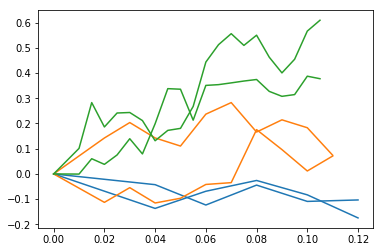

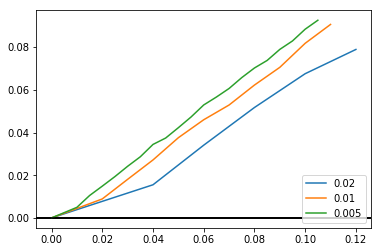

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import nengo
from kalman import LDS, LDSNet

def test_ldsnet_noise_implementation():
    """Test an integrator driven by noise"""
    SIM_TIME = 0.1
    N_RUNS = 1000
#     dts = [0.01, 0.001]
    dts = [0.02, 0.01, 0.005]
    fig_runs, ax_runs = plt.subplots()
    fig_var, ax_var = plt.subplots()
    for dt in dts:
        state_data = np.zeros((N_RUNS, int(np.round(SIM_TIME/dt))+1))

        A = np.array([[0]])
        B = np.array([[0]])
        C = np.array([[0]])
        Q = np.array([[1]])
        R = np.array([[0]])

        model = nengo.Network()
        with model:
            stim = nengo.Node([0])
            lds_net = LDSNet(A, B, C, Q=Q, R=R, dt=dt)
            nengo.Connection(stim, lds_net.input, synapse=None)
            stim_probe = nengo.Probe(stim)
            lds_probe = nengo.Probe(lds_net.state)
            out_probe = nengo.Probe(lds_net.output)

        sim = nengo.Simulator(model, progress_bar=False, dt=dt)
        fig_run = plt.figure()
        for run_idx in range(N_RUNS):
            sim.run(SIM_TIME+dt)
            state_data[run_idx, :] = sim.data[lds_probe][:, 0]
            if run_idx == 0:
                trange = np.array([0] + list(sim.trange())[1:])
                color = ax_runs.plot(trange, state_data[run_idx])[0].get_color()
            elif run_idx == 1:
                ax_runs.plot(trange, state_data[run_idx], color=color)
            sim.reset()
            
        var = np.var(state_data, axis=0)
        ax_var.plot(trange, var, label=dt)
        ax_var.axhline(0, color="k")
    ax_var.legend(loc="lower right")
test_ldsnet_noise_implementation()

Building finished in 0:00:01.                                                                                                                                                                                       
Simulating finished in 0:00:01.                                                                                                                                                                                     


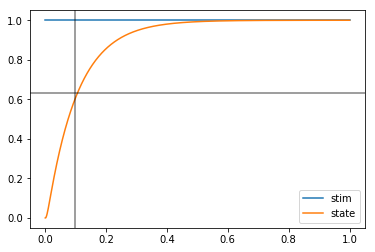

In [2]:
def test_ldsnet_1d():
    """Test LDSNet correctness
    
    tau xdot = -x + u
    """
    SIM_TIME = 1.
    TAU = 0.1
    A = np.array([[-1/TAU]])
    B = np.array([[1/TAU]])
    C = np.array([[1]])
    model = nengo.Network()
    with model:
        stim = nengo.Node([1])
        lds_net = LDSNet(A, B, C)
        
        nengo.Connection(stim, lds_net.input)
        
        stim_probe = nengo.Probe(stim)
        lds_probe = nengo.Probe(lds_net.state)
    
    sim = nengo.Simulator(model, dt=0.001)
    sim.run(SIM_TIME)
    
    plt.plot(sim.trange(), sim.data[stim_probe], label="stim")
    plt.plot(sim.trange(), sim.data[lds_probe], label="state")
    plt.axvline(TAU, color='k', alpha=0.5)
    plt.axhline(1-np.exp(-1), color="k", alpha=0.5)
    plt.legend(loc="lower right")
    plt.show()
test_ldsnet_1d()

Building finished in 0:00:01.                                                                                                                                                                                       
Simulating finished in 0:00:01.                                                                                                                                                                                     


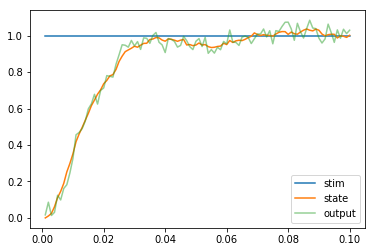

In [14]:
def test_ldsnet_1d_noisy():
    """Test a low-pass filter with constant input"""
    SIM_TIME = 0.1
    TAU = 0.01

    dt = 0.001
    A = np.array([[-1/TAU]])
    B = np.array([[1/TAU]])
    C = np.array([[1]])
    Q = np.array([[0.1/dt]])
    R = np.array([[0.001]])
    
    model = nengo.Network()
    with model:
        stim = nengo.Node([1])
        lds_net = LDSNet(A, B, C, Q=Q, R=R)
        nengo.Connection(stim, lds_net.input, synapse=None)
        stim_probe = nengo.Probe(stim)
        lds_probe = nengo.Probe(lds_net.state)
        out_probe = nengo.Probe(lds_net.output)
        
    sim = nengo.Simulator(model, dt=dt)
    sim.run(SIM_TIME)
    
    plt.plot(sim.trange(), sim.data[stim_probe], label="stim")
    plt.plot(sim.trange(), sim.data[lds_probe], label="state")
    plt.plot(sim.trange(), sim.data[out_probe], alpha=0.5, label="output")
    plt.legend(loc="lower right")
    plt.show()
test_ldsnet_1d_noisy()

Building finished in 0:00:01.                                                                                                                                                                                       
Simulating finished in 0:00:01.                                                                                                                                                                                     


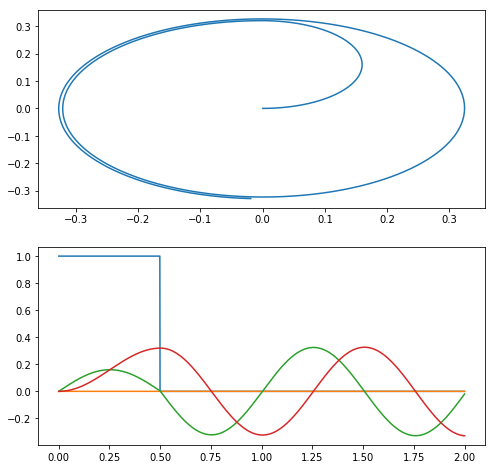

In [6]:
def test_stim(t, stop_time):
    if t < stop_time:
        return [1, 0]
    else:
        return [0, 0]

def test_ldsnet_2d():
    """Test LDSNet correctness
    
    tau xdot = -x + u
    """
    SIM_TIME = 2.
    STIM_TIME = 0.5
    THETA = np.pi/2
    TAU = 0.1
    A = 2*np.pi*np.array(
        [[np.cos(THETA), -np.sin(THETA)],
         [np.sin(THETA), np.cos(THETA)]])
    B = np.eye(2)
    C = np.eye(2)
    
    model = nengo.Network()
    with model:
        stim = nengo.Node(lambda t: test_stim(t, STIM_TIME))
        lds_net = LDSNet(A, B, C)
        nengo.Connection(stim, lds_net.input, synapse=None)
        
        stim_probe = nengo.Probe(stim)
        lds_probe = nengo.Probe(lds_net.state)
    
    sim = nengo.Simulator(model, dt=0.001)
    sim.run(SIM_TIME)
    
    fig, axs = plt.subplots(nrows=2, figsize=(8, 8))
    axs[0].plot(sim.data[lds_probe][:, 0], sim.data[lds_probe][:, 1])
    axs[1].plot(sim.trange(), sim.data[stim_probe], label="stim")
    axs[1].plot(sim.trange(), sim.data[lds_probe], label="state")
    plt.show()
test_ldsnet_2d()

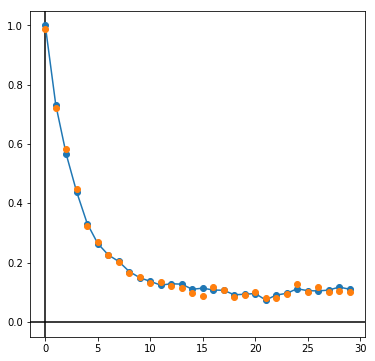

In [2]:
def test_1d():
    """Test a low-pass filter with constant input"""
    N_STEP = 30
    
    A = np.array([[0.7]])
    B = np.array([[0.3]])
    C = np.array([[1]])
    D = np.array([[0]])
    x0 = np.array([1])
    Q = np.array([[0.0001]])
    R = np.array([[0.0001]])
    
    x = np.zeros((N_STEP, 1))
    y = np.zeros((N_STEP, 1))
    u = np.array([0.1])

    lds = LDS(A, B, C, D, x0, Q, R)
    x[0], y[0] = lds.initial_condition
    for n in range(N_STEP)[1:]:
        x[n], y[n] = lds.step(u)
        
    plt.figure(figsize=(6,6))
    plt.axhline(0, color='k')
    plt.axvline(0, color='k')
    plt.plot(x, '-o')
    plt.plot(y, 'o')
    plt.show()
test_1d()

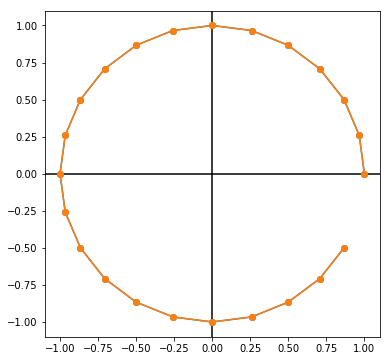

In [3]:
def test_rotation():
    """Test that LDS can implement autonomous rotation"""
    theta = np.pi/12
    N_STEP = int(2*np.pi/theta)-1

    A = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    B = np.zeros((2, 2))
    C = np.eye(2)
    D = np.zeros((2, 2))
    x0 = np.array([1, 0])

    Q = np.zeros((2, 2))
    R = np.zeros((2, 2))

    x = np.zeros((N_STEP, 2))
    y = np.zeros((N_STEP, 2))
    u = np.zeros(2)

    lds = LDS(A, B, C, D, x0, Q, R)
    x[0], y[0] = lds.initial_condition

    for n in range(N_STEP)[1:]:
        x[n], y[n] = lds.step(u)

    plt.figure(figsize=(6,6))
    plt.axhline(0, color='k')
    plt.axvline(0, color='k')
    plt.plot(x[:, 0], x[:, 1], '-o')
    plt.plot(y[:, 0], y[:, 1], '-o')
    plt.xlim([-1.1, 1.1])
    plt.ylim([-1.1, 1.1])
    plt.show()
test_rotation()

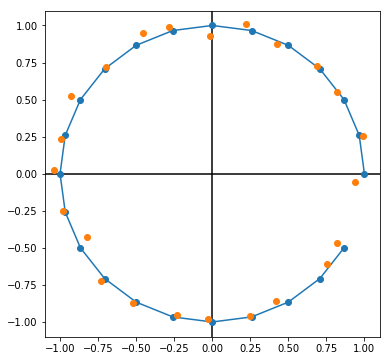

In [4]:
def test_rotation_noisy():
    """Test that LDS can implement autonomous rotation with observer noise"""
    theta = np.pi/12
    N_STEP = int(2*np.pi/theta)-1

    A = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    B = np.zeros((2, 2))
    C = np.eye(2)
    D = np.zeros((2, 2))
    x0 = np.array([1, 0])

    Q = np.zeros((2, 2))
    R = 0.002*np.eye(2)

    x = np.zeros((N_STEP, 2))
    y = np.zeros((N_STEP, 2))
    u = np.zeros(2)

    lds = LDS(A, B, C, D, x0, Q, R)
    x[0], y[0] = lds.initial_condition

    for n in range(N_STEP)[1:]:
        x[n], y[n] = lds.step(u)

    plt.figure(figsize=(6,6))
    plt.axhline(0, color='k')
    plt.axvline(0, color='k')
    plt.plot(x[:, 0], x[:, 1], '-o')
    plt.plot(y[:, 0], y[:, 1], 'o')
    plt.xlim([-1.1, 1.1])
    plt.ylim([-1.1, 1.1])
    plt.show()
test_rotation_noisy()